In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm

from algorithms.astar2k import astar2k
from algorithms.thetastar import thetastar
from algorithms.anya import anya
from algorithms.structures import Map, Node, AnyaMap
from util.containers import Open, Closed, OpenAnya
from util import functions as uf
from test import movingai_util as mutil
from draw.draw import draw
import random
import time
%matplotlib inline

In [2]:
def simple_test(search_func, task, *args):
    height = 15
    width = 30
    map_str = '''
. . . . . . . . . . . . . . . . . . . . . # # . . . . . . .  
. . . . . . . . . . . . . . . . . . . . . # # . . . . . . . 
. . . . . . . . . . . . . . . . . . . . . # # . . . . . . . 
. . . # # . . . . . . . . . . . . . . . . # # . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . # # . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . # # # # # . . . . 
. . . # # . . . . . . . . # # . . . . . . # # # # # . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . # # . . . . . . . . . . . . . . .
. . . . . . . . . . . . . # # . . . . . . . . . . . . . . .
'''

    task_map = AnyaMap()
    task_map.read_from_string(map_str, width, height)
    starts = [(9, 0), (13, 0), (7, 28), (14, 29), (4, 1), (0, 17), (5, 6), (5, 20), (12, 2), (7, 28), (11, 9), (3, 2), (3, 17), (13, 20), (1, 1), (9, 10), (14, 6), (2, 0), (9, 28), (8, 6), (11, 6), (3, 0), (8, 9), (14, 7), (12, 4), (7, 30), (7, 0)]
    goals = [(11, 20), (2, 19), (6, 5), (4, 18), (9, 20), (7, 0), (2, 25), (12, 4), (3, 25), (0, 12), (4, 23), (2, 24), (9, 2), (1, 6), (13, 29), (14, 29), (2, 28), (14, 16), (13, 0), (1, 27), (14, 25), (10, 20), (12, 28), (2, 29), (1, 29), (7, 0), (7, 30)]
    lengths = [36, 30, 30, 21, 28, 24, 32, 27, 42, 23, 35, 37, 23, 26, 40, 36, 42, 28, 44, 36, 38, 29, 33, 42, 44, 0, 0]

    if (task is None) or not (0 <= task < 27):
        task = random.randint(0, 24)

    start = Node(*starts[task])
    goal = Node(*goals[task])
    length = lengths[task]
    try:
        result = search_func(task_map, start.i, start.j, goal.i, goal.j, *args)
        number_of_steps = result[2]
        nodes_created = result[3]
        if result[0]:
            path = uf.make_path(result[1])
            correct = uf.check_correcting_and_optimality(result[1], task_map)
            print("Path found! Length: " + str(path[1]) + \
                ". Nodes created: " + str(nodes_created) + \
                ". Number of steps: " + str(number_of_steps) + ". Optimality and correct: " + str(correct))
            draw(task_map, start, goal, path[0], *result[4:])
        else:
            print("Path not found!")
            draw(task_map, start, goal, [start], *result[4:])
        return result

    except Exception as e:
        print("Execution error")
        print(e)


10 6 is not corner
Path found! Length: 25.0. Nodes created: 368. Number of steps: 181. Optimality and correct: False


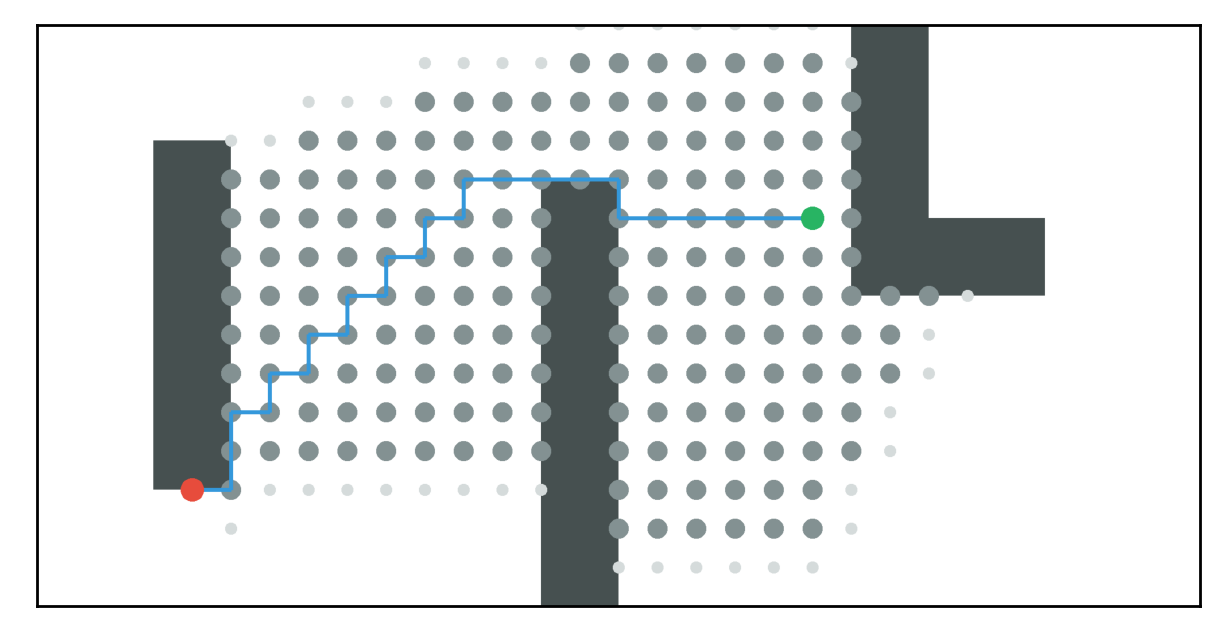

11 6 is not corner
Path found! Length: 19.549776476484556. Nodes created: 660. Number of steps: 71. Optimality and correct: False


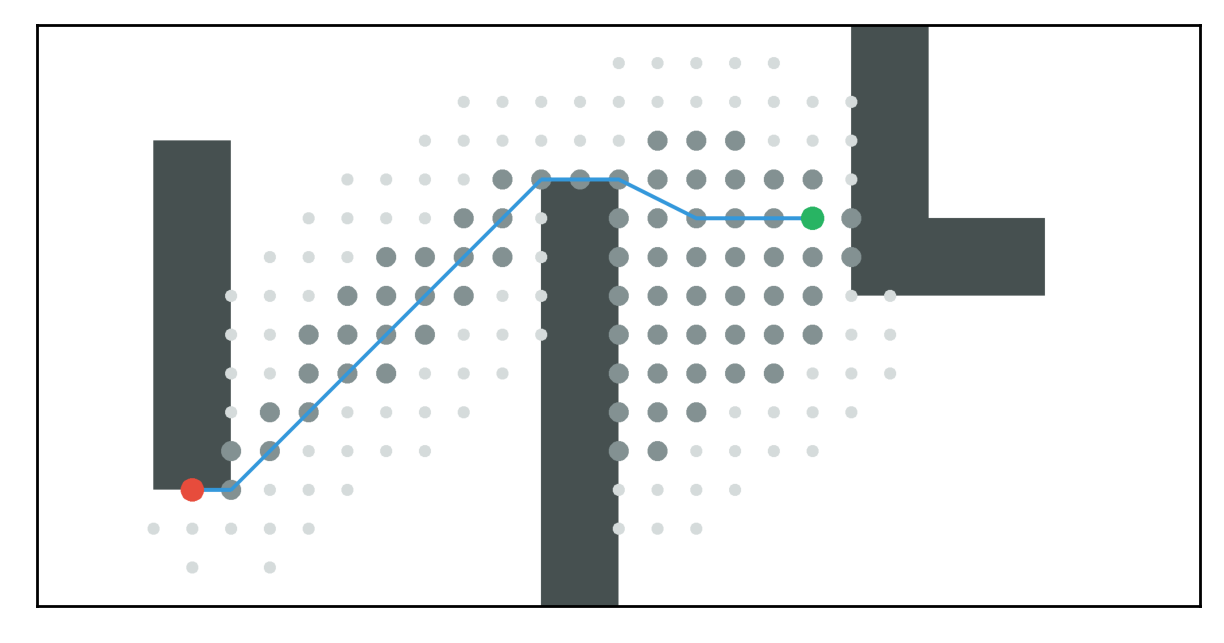

Path found! Length: 19.412728012577546. Nodes created: 169. Number of steps: 75. Optimality and correct: True


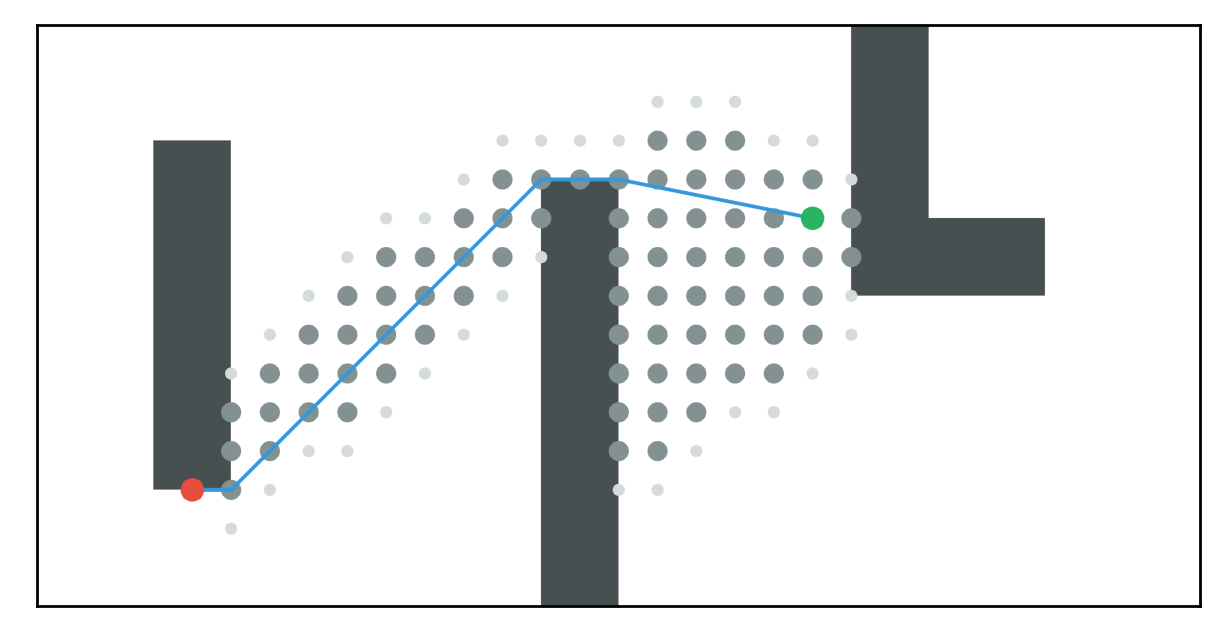

Path found! Length: 19.412728012577546. Nodes created: 27. Number of steps: 20. Optimality and correct: True


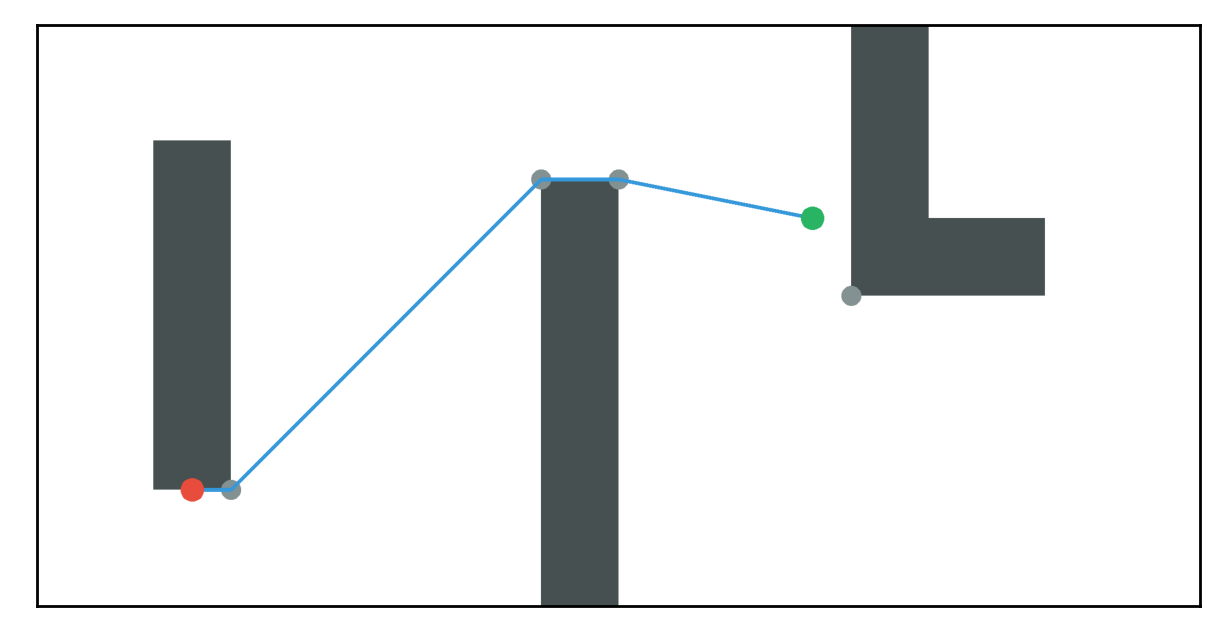

In [3]:
for i in range(7, 8):
    simple_test(astar2k, i, uf.euclidian_distance, Open, Closed, 2)
    simple_test(astar2k, i, uf.euclidian_distance, Open, Closed, 4)
    simple_test(thetastar, i, uf.euclidian_distance)
    simple_test(anya, i, uf.euclidian_distance)

In [4]:
cities = ["Berlin_0_512", "Boston_0_512", "Denver_0_512", "London_0_512", "Milan_0_512", "Moscow_0_512", "NewYork_0_512", "Paris_0_512", "Shanghai_0_512", "Sydney_0_512"]
games = ["tranquilpaths", "thecrucible", "plunderisle", "petrifiedforest", "moonglade"]
random10 = ["random512-10-0", "random512-10-1"]
rooms = ["16room_000", "32room_000", "64room_000"]

In [5]:
def massive_test(maps, tasks_per_map=1, draw_paths=True, mask=[1, 0, 0, 1, 1], random_seed=932):
    df = pd.DataFrame(columns=["4-a*-len", "32-a*-len", "256-a*-len", "th*-len", "anya-len"]
                     + ["4-a*-time", "32-a*-time", "256-a*-time", "th*-time", "anya-time"]
                     + ["4-a*-exp", "32-a*-exp", "256-a*-exp", "th*-exp", "anya-exp"])
    prefixes_template = ["4-a*", "32-a*", "256-a*", "th*", "anya"]
    prefixes = []
    for i in range(5):
        if mask[i]:
            prefixes.append(prefixes_template[i])

    for m in maps:
        map_path = f"test/data/{m}.map"
        tasks_path = f"test/data/{m}.map.scen"
        task_map = mutil.read_map_from_movingai_file(map_path, AnyaMap)
        tasks = mutil.read_tasks_from_movingai_file(tasks_path)
        random.seed(random_seed)
        random.shuffle(tasks)


        for i in range(tasks_per_map):
            (s_i, s_j, f_i, f_j, l) = tasks[i]
            start = Node(i = s_i, j = s_j)
            goal = Node(i = f_i, j = f_j)

            results = []
            times = []
            if mask[0]:
                s_t = time.time()
                results.append(astar2k(task_map, start.i, start.j, goal.i, goal.j, uf.euclidian_distance, k=2))
                times.append(time.time() - s_t)
            if mask[1]:
                s_t = time.time()
                results.append(astar2k(task_map, start.i, start.j, goal.i, goal.j, uf.euclidian_distance, k=5))
                times.append(time.time() - s_t)
            if mask[2]:
                s_t = time.time()
                results.append(astar2k(task_map, start.i, start.j, goal.i, goal.j, uf.euclidian_distance, k=8))
                times.append(time.time() - s_t)
            if mask[3]:
                s_t = time.time()
                results.append(thetastar(task_map, start.i, start.j, goal.i, goal.j, uf.euclidian_distance))
                times.append(time.time() - s_t)
            if mask[4]:
                s_t = time.time()
                results.append(anya(task_map, start.i, start.j, goal.i, goal.j, uf.euclidian_distance))
                times.append(time.time() - s_t)
            
            paths = []
            new_row = {}
            labels = dict()
            for i in range(len(prefixes)):
                if results[i][0]:
                    path, length = uf.make_path(results[i][1])
                    paths.append(path)
                    labels[i]=f"{prefixes[i]} : {length:.2f}"
                else:
                    length = -1
                new_row[f"{prefixes[i]}-len"] = length
                new_row[f"{prefixes[i]}-time"] = times[i]
                new_row[f"{prefixes[i]}-exp"] = results[i][2]
                
            if draw_paths:
                draw(task_map, start, goal, paths=paths, labels=labels)
            
            df = df.append(new_row, ignore_index=True)
    return df, df[df.columns[~df.isnull().all()]]

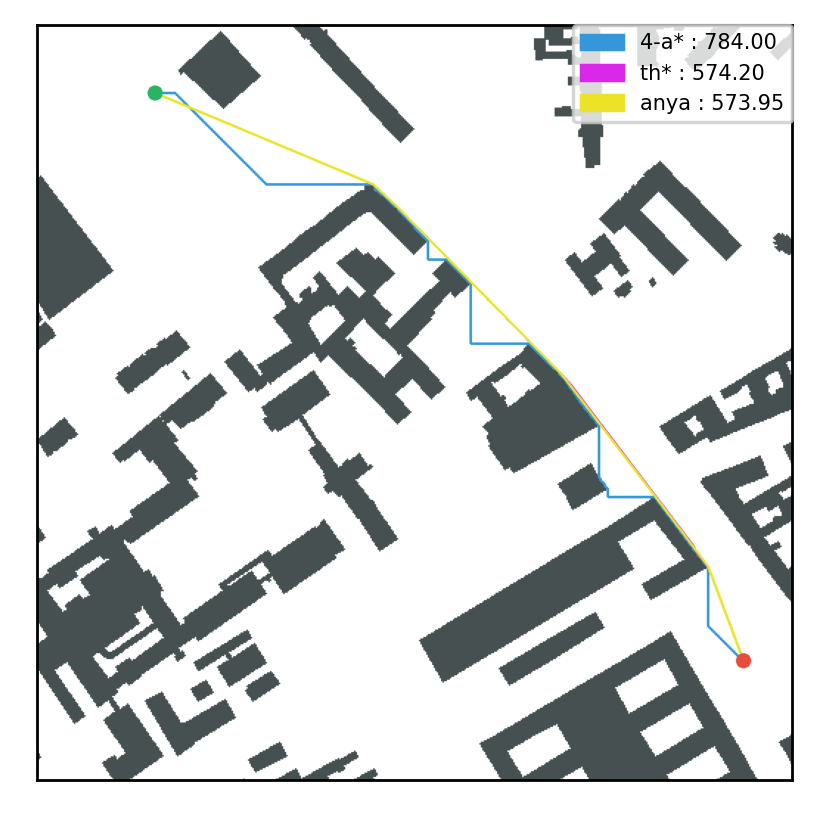

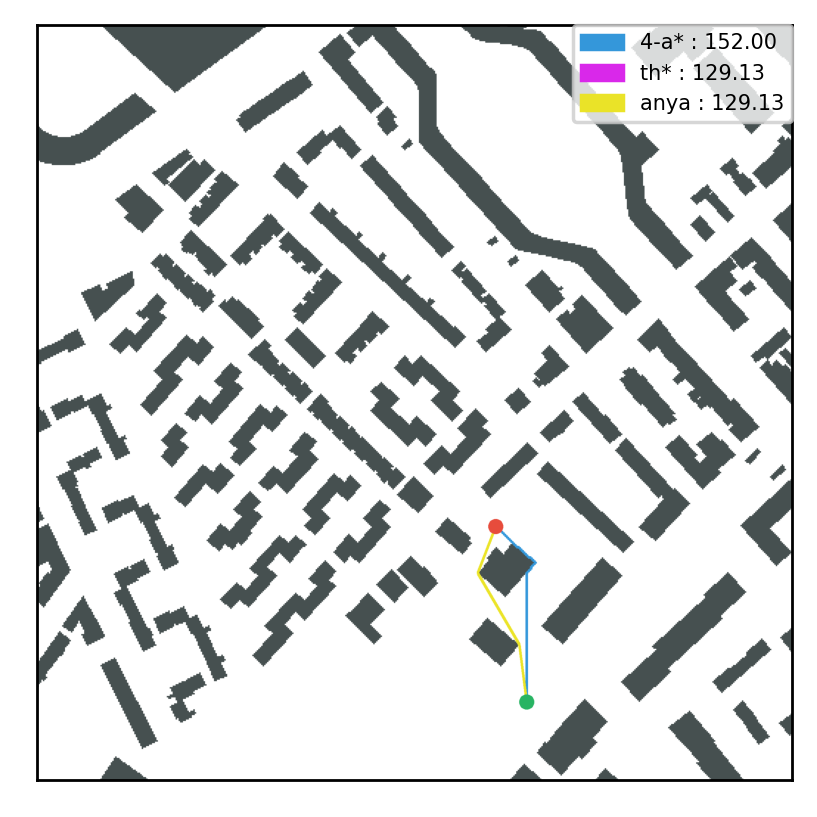

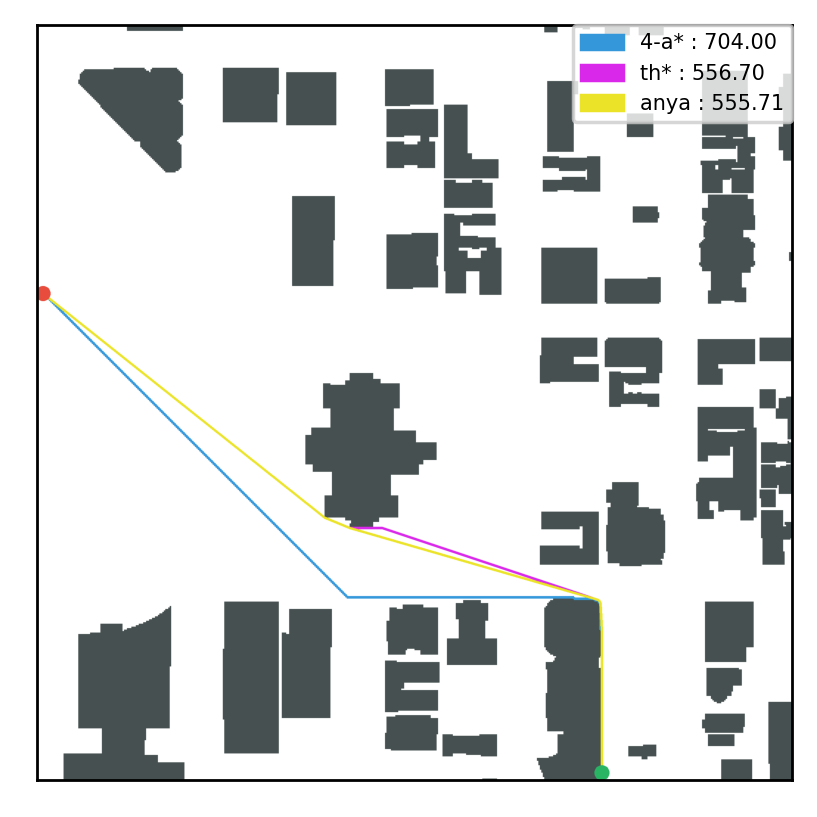

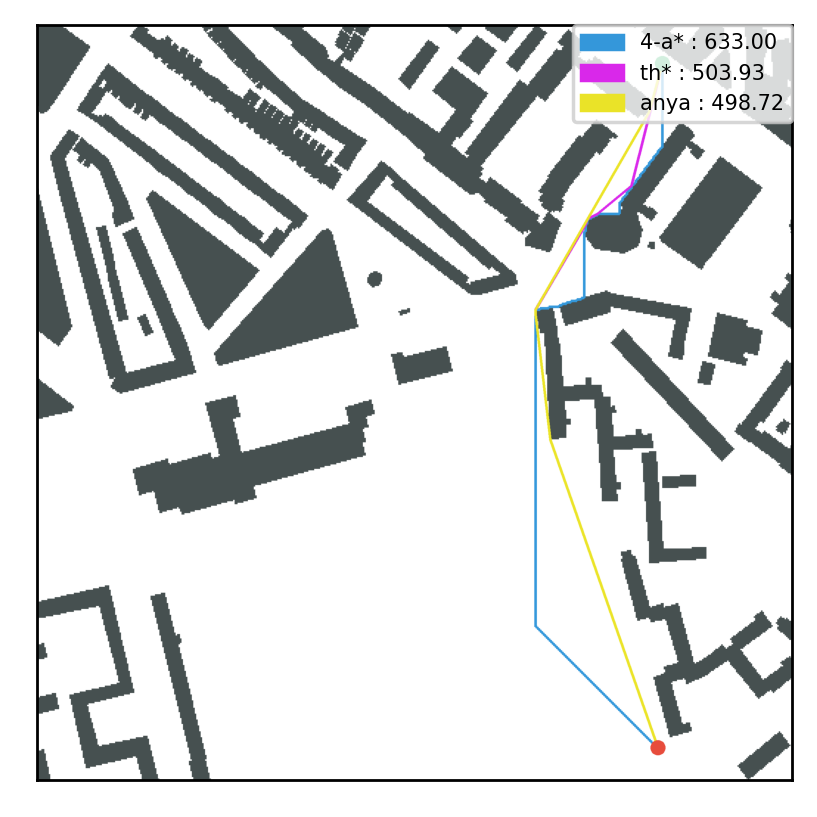

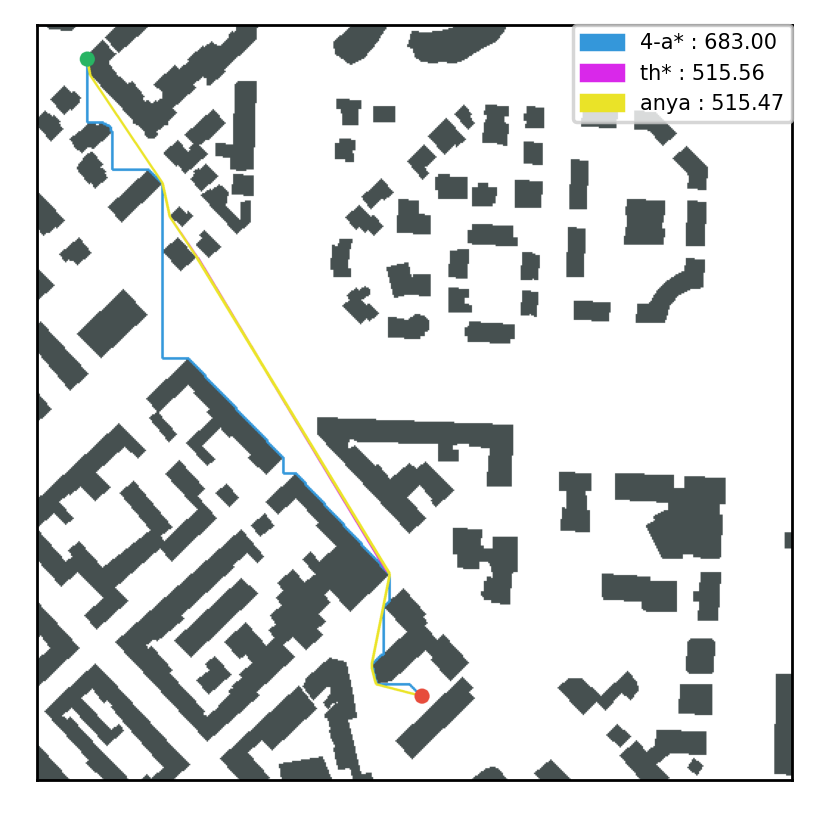

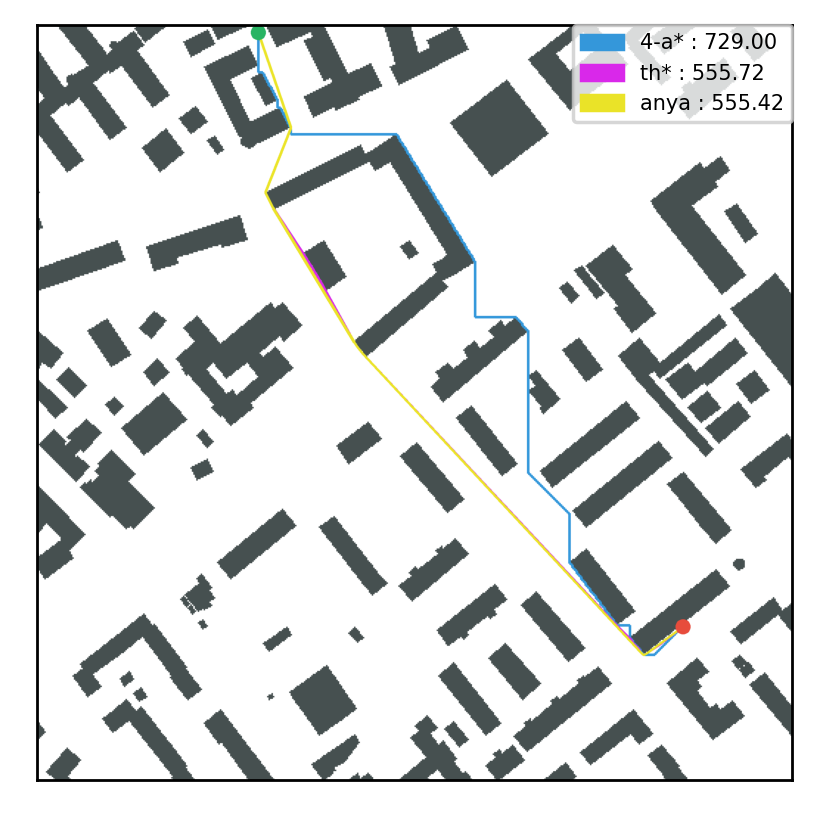

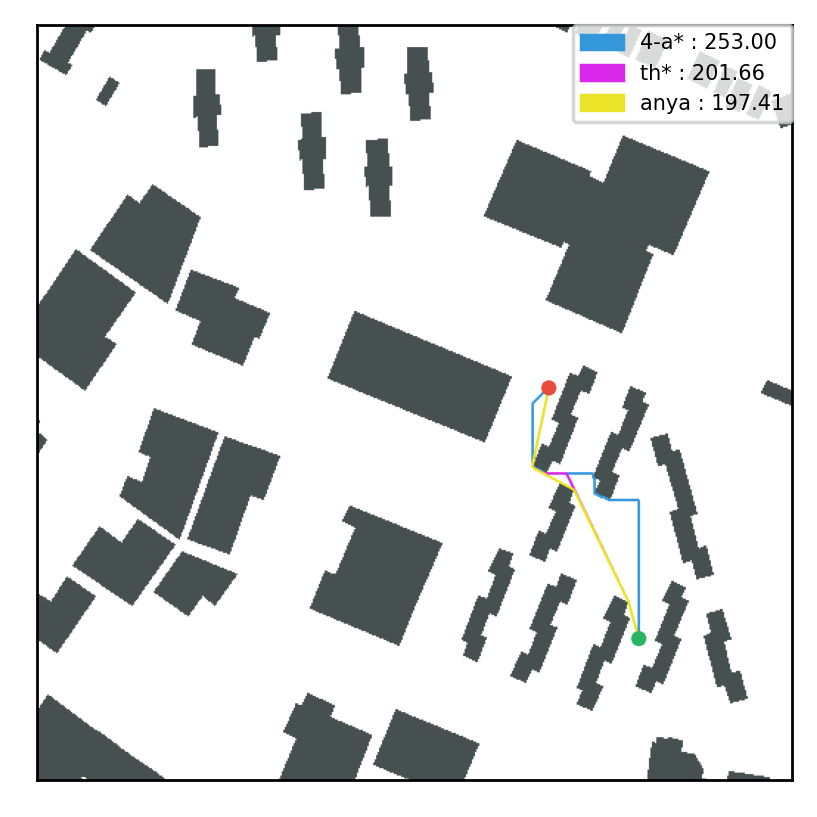

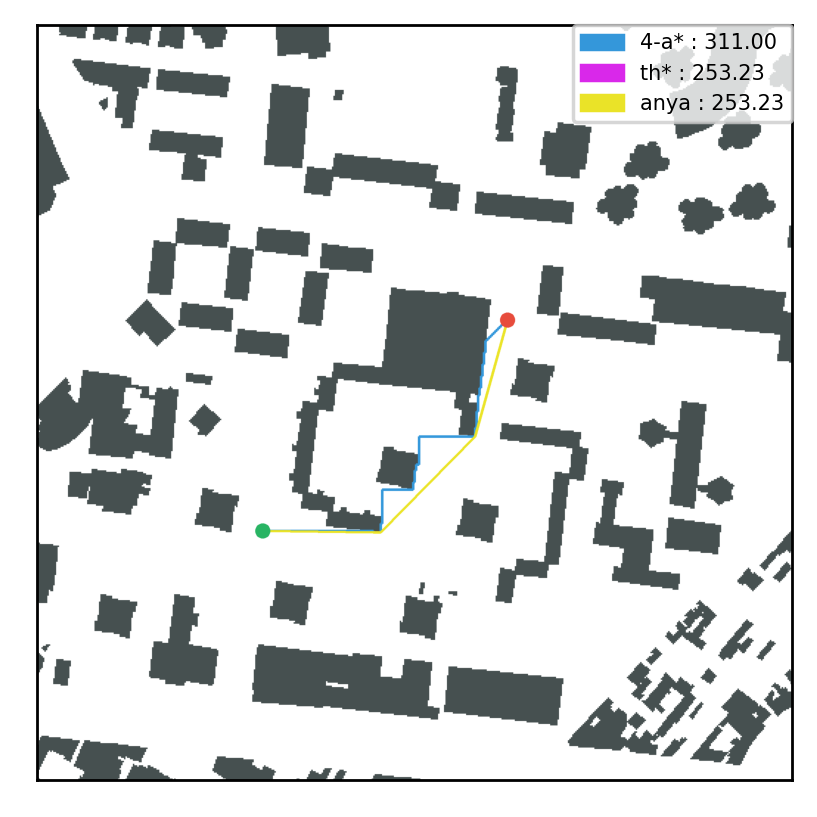

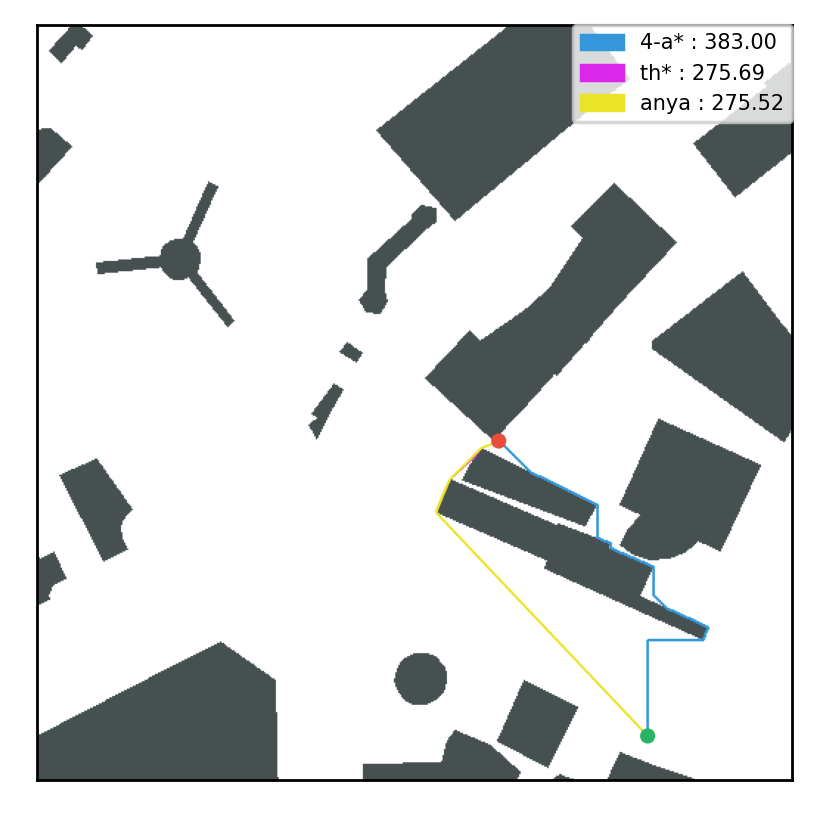

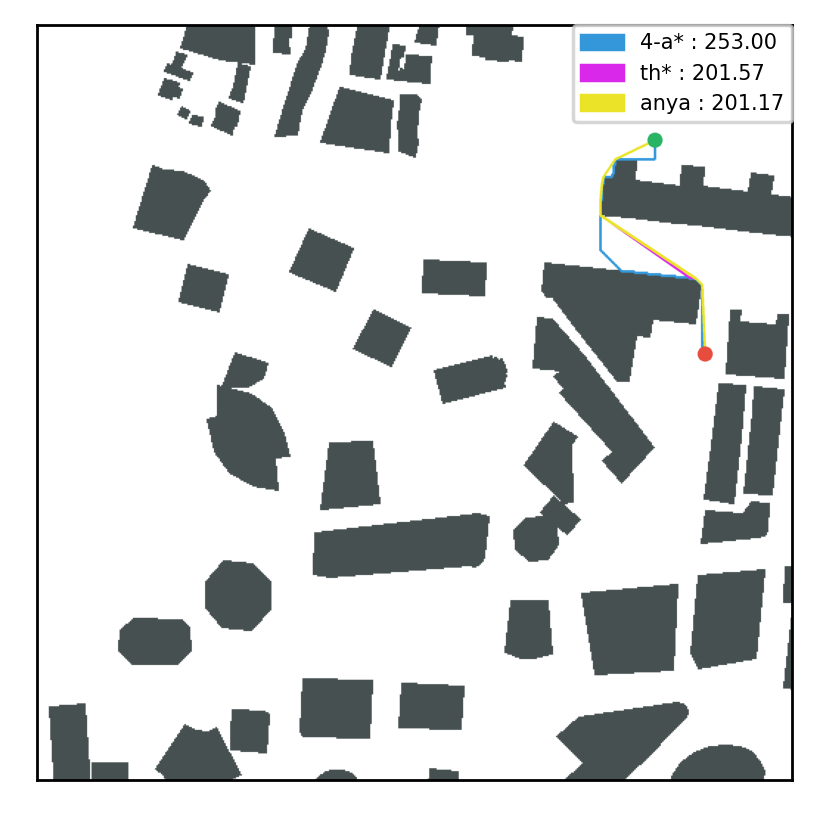

In [6]:
df, df_filtered = massive_test(cities, 1)

In [7]:
display(df_filtered)
df_filtered.describe()

,4-a*-len,th*-len,anya-len,4-a*-time,th*-time,anya-time,4-a*-exp,th*-exp,anya-exp
0,784.0,574.204626,573.945250,3.536467,13.391370,1.982778,134628.0,20451.0,10697.0
1,152.0,129.130523,129.130523,0.101541,1.187461,0.125263,4957.0,2956.0,917.0
2,704.0,556.700595,555.711730,2.420993,6.110731,0.250089,99320.0,12633.0,1355.0
3,633.0,503.932164,498.721925,1.777099,13.607787,1.813308,74241.0,30067.0,15677.0
4,683.0,515.561490,515.466033,1.835649,21.572323,6.300987,76413.0,35113.0,44578.0
5,729.0,555.724754,555.416849,2.775914,35.657568,8.920155,117471.0,67082.0,77788.0
6,253.0,201.663964,197.405101,0.283251,4.767982,0.294283,14285.0,8861.0,2981.0
7,311.0,253.232279,253.232279,0.553784,3.126351,0.175446,25175.0,9494.0,1449.0
8,383.0,275.692916,275.523067,0.859851,12.186159,1.580527,37663.0,18357.0,3869.0
9,253.0,201.570975,201.168493,0.332100,1.707654,0.163360,13676.0,7373.0,643.0


,4-a*-len,th*-len,anya-len,4-a*-time,th*-time,anya-time,4-a*-exp,th*-exp,anya-exp
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,488.500000,376.741429,375.572125,1.447665,11.331539,2.160619,59782.900000,21238.700000,15995.400000
std,239.699001,178.566458,178.497715,1.196788,10.749510,3.028177,46983.763383,19069.132026,25536.210544
min,152.000000,129.130523,129.130523,0.101541,1.187461,0.125263,4957.000000,2956.000000,643.000000
25%,267.500000,214.556043,214.184440,0.387521,3.536759,0.194107,17007.500000,9019.250000,1378.500000
50%,508.000000,389.812540,387.122496,1.318475,9.148445,0.937405,55952.000000,15495.000000,3425.000000
75%,698.750000,545.683938,545.429145,2.274657,13.553683,1.940410,93593.250000,27663.000000,14432.000000
max,784.000000,574.204626,573.945250,3.536467,35.657568,8.920155,134628.000000,67082.000000,77788.000000
